In [2]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
import pandas as pd
import glob
import os
import pypfopt as pyp
import quantstats as qs
import numpy as np
import matplotlib.pyplot as plt
import utils as u
%load_ext autoreload

In [98]:
hour_df_mid_usd = pd.read_csv('../cleaned_data/hour_data_mid_usd.csv', index_col=[0])
hour_df_mid_usd.index = pd.to_datetime(hour_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York')
hour_df_usd_price = (1/hour_df_mid_usd).fillna(method='ffill')
hour_df_usd_returns = hour_df_usd_price.pct_change()
hour_df_usd_returns = hour_df_usd_returns.dropna()
hour_df_usd_returns = hour_df_usd_returns.drop(columns=['USD.TRY.SPOT'])
hour_df_usd_price_tr = hour_df_usd_price.loc[:'2022-05-30']
hour_df_usd_returns_tr = hour_df_usd_returns.loc[:'2022-05-30']
hour_df_usd_returns_tr

,USD.EUR.SPOT,USD.JPY.SPOT,USD.CAD.SPOT,USD.AUD.SPOT,USD.GBP.SPOT,USD.NZD.SPOT,USD.MXN.SPOT,USD.NOK.SPOT,USD.SEK.SPOT
time_utc,,,,,,,,,
2022-01-02 19:00:00-05:00,-0.000954,-0.001188,0.000462,-0.000275,-0.000322,0.001192,0.000037,-0.001069,-0.001109
2022-01-02 20:00:00-05:00,-0.000304,0.000586,-0.000655,-0.001369,0.000030,-0.001395,-0.000836,-0.001072,0.001175
2022-01-02 21:00:00-05:00,-0.001400,-0.000555,-0.000868,-0.000475,-0.000973,-0.000841,-0.000983,-0.002292,-0.001356
2022-01-02 22:00:00-05:00,0.000498,0.000004,-0.000426,-0.000490,-0.000367,-0.000139,-0.000310,0.000468,0.000469
2022-01-02 23:00:00-05:00,-0.000683,0.000056,0.000146,0.000097,-0.000081,-0.000059,-0.000366,-0.000623,-0.000673
...,...,...,...,...,...,...,...,...,...
2022-05-30 19:00:00-04:00,-0.000195,-0.001276,0.000190,0.000438,-0.000237,0.000267,0.000320,0.000663,0.000366
2022-05-30 20:00:00-04:00,-0.002571,-0.003202,-0.001538,-0.002780,-0.002645,-0.003211,-0.002333,-0.003996,-0.002856
2022-05-30 21:00:00-04:00,0.000475,0.000215,0.000521,0.000753,0.000797,-0.000589,0.000457,0.001293,-0.000134


In [13]:
minute_df_mid_usd = pd.read_csv('../cleaned_data/minute_data_mid_usd.csv', index_col='time_utc')
minute_df_mid_usd.index = pd.to_datetime(minute_df_mid_usd.index).tz_localize('UTC').tz_convert('America/New_York')
minute_df_usd_price = (1/minute_df_mid_usd).fillna(method='ffill')
minute_df_usd_returns = minute_df_usd_price.pct_change()

# drop the first minute after the hour break
minute_df_usd_returns = minute_df_usd_returns[~((minute_df_usd_returns.index.hour ==18) & (minute_df_usd_returns.index.minute == 1))].dropna()
minute_df_usd_returns = minute_df_usd_returns.drop(columns=['USD.TRY.SPOT'])
minute_df_usd_price_tr = minute_df_usd_price.loc[:'2022-05-30']
minute_df_usd_returns_tr = minute_df_usd_returns.loc[:'2022-05-30']



In [15]:
df_dict = {}
returns_dict = {}
for p in range(0,24):
    if p!=17:
        df_dict[p] = minute_df_usd_price_tr[minute_df_usd_price_tr.index.hour ==p]
        returns_dict[p] = minute_df_usd_returns_tr[minute_df_usd_returns_tr.index.hour ==p]

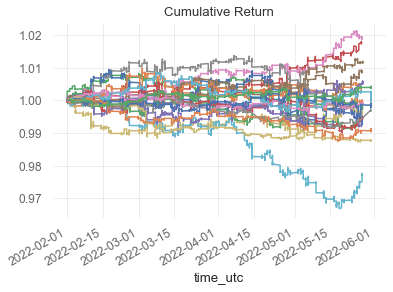

In [16]:
returns_static_dict = {}
cumul_returns_static_dict = {}
vol_static = []
port_static_dict ={}
s_date = '2022-01-31'
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],None,len(returns_dict[x][:s_date]),static_start_date=s_date,verbose=False,returns_data=True)
    port_static_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_static_dict[x] =bt[0]
    vol_static.append(bt[1])
    returns_static_dict[x] =bt[2]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23')])

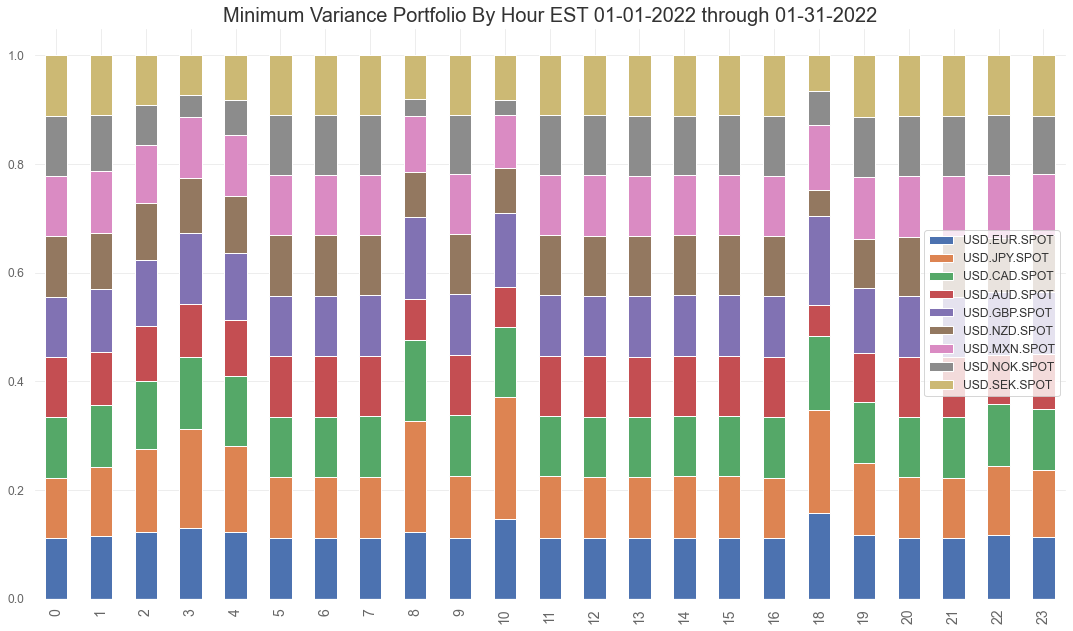

In [17]:
weight_df = pd.concat(port_static_dict, axis=0).droplevel(axis=0,level=0)
weight_df.index = weight_df.index.hour
ax = weight_df.plot.bar(stacked=True)
ax.legend(loc=5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.axes.set_title("Minimum Variance Portfolio By Hour EST 01-01-2022 through 01-31-2022", fontsize=20)
plt.xticks(fontsize=14)

([<matplotlib.axis.XTick at 0x1cd7efb2be0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

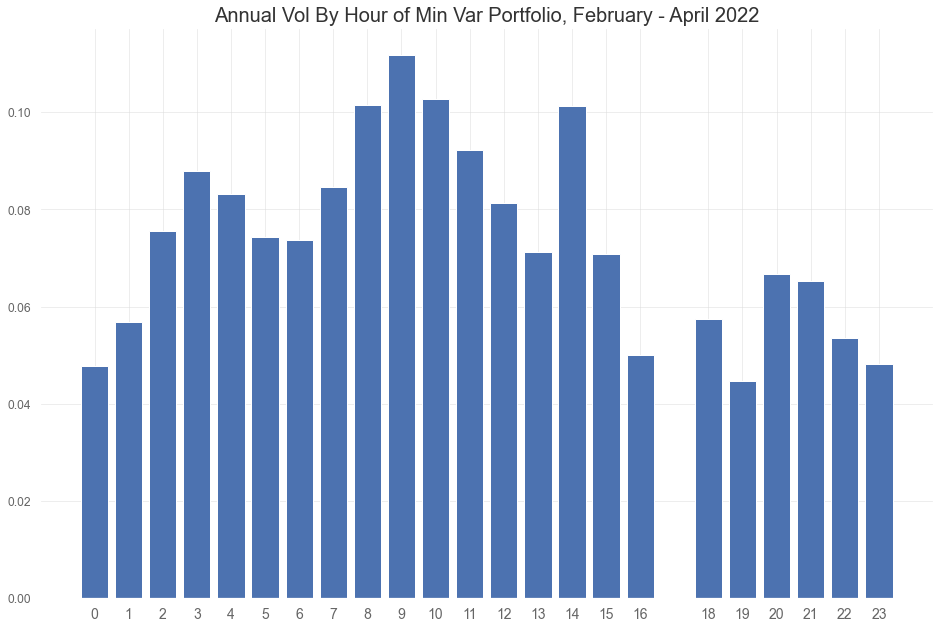

In [18]:
vol_static_ann= np.array(vol_static)*(60*23*252)**(1/2)
plt.bar(weight_df.index,vol_static_ann)
plt.title("Annual Vol By Hour of Min Var Portfolio, February - April 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)

### Rolling 2-1-2022 thru 5-31-2022

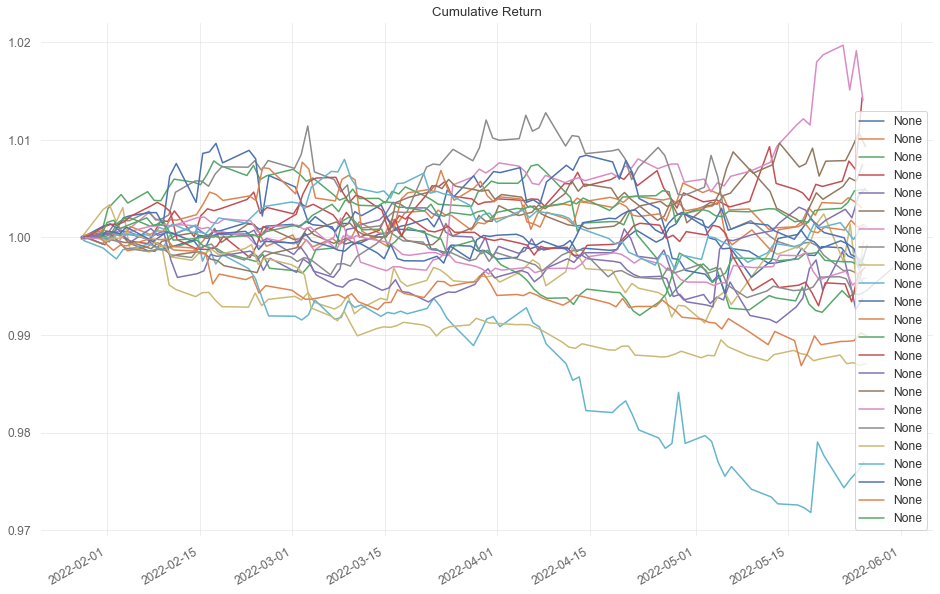

In [38]:
returns_rolling_dict = {}
cumul_returns_rolling_dict = {}
vol_rolling = []
port_rolling_dict ={}
for x in df_dict.keys():
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],60,60*10,static_start_date='2022-01-31',verbose=False,returns_data=True)
    port_rolling_dict[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_returns_rolling_dict[x] =bt[0]
    vol_rolling.append(bt[1])
    returns_rolling_dict[x] =bt[2]
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16, 10.5)

In [20]:
from copy import deepcopy

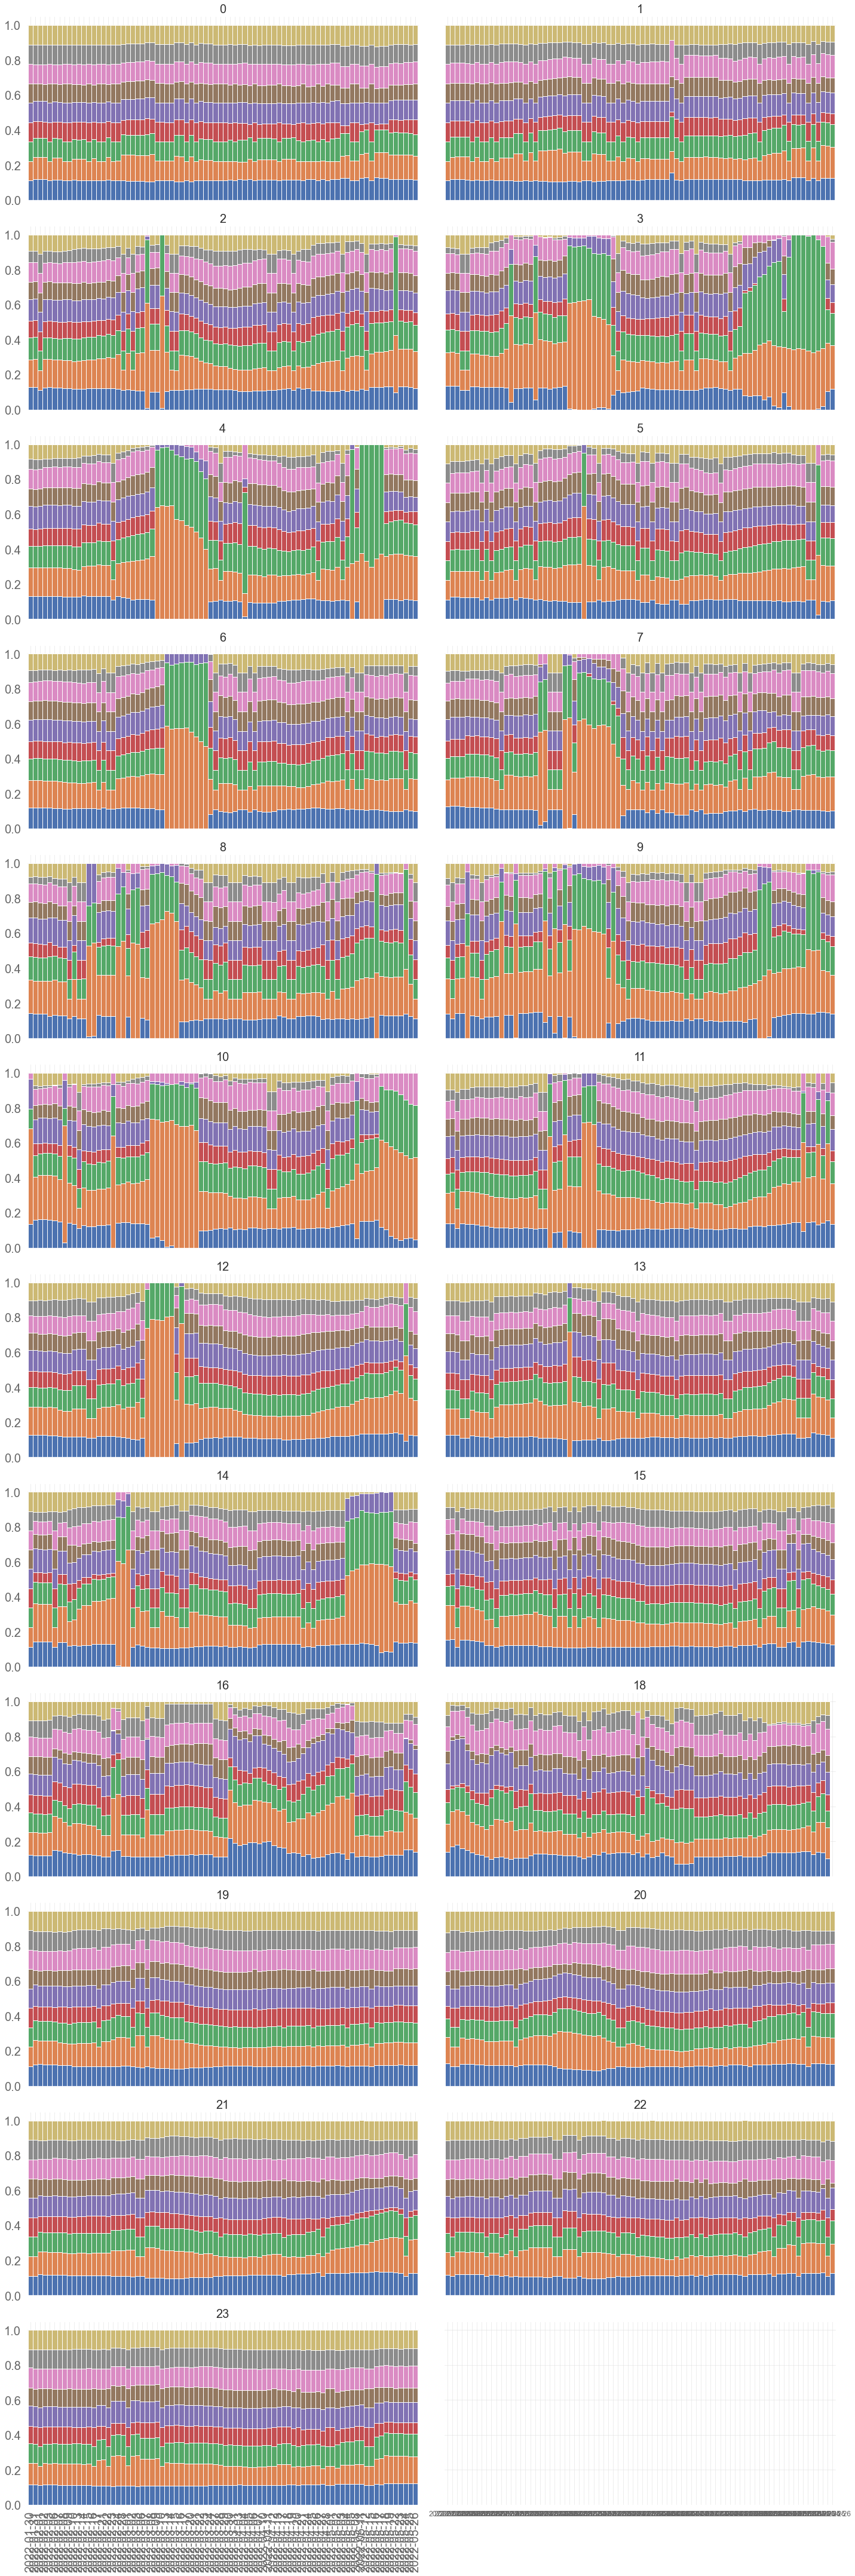

In [21]:
port_rolling_dict_g = deepcopy(port_rolling_dict)
fig, axarr = plt.subplots(int(len(port_rolling_dict_g.keys())/2+1),2, figsize=(20,60), sharex=True, sharey=True)
i=0
for x in port_rolling_dict.keys():
    port_rolling_dict_g[x].index = port_rolling_dict_g[x].index.date
    port_rolling_dict_g[x].plot.bar(ax=axarr[int(i/2)][i%2],stacked=True, legend=False, width=1.0,fontsize=20)
    axarr[int(i/2)][i%2].set_title(str(x), fontsize=20)
    i+=1
fig.tight_layout()

([<matplotlib.axis.XTick at 0x1cd7dd35b50>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

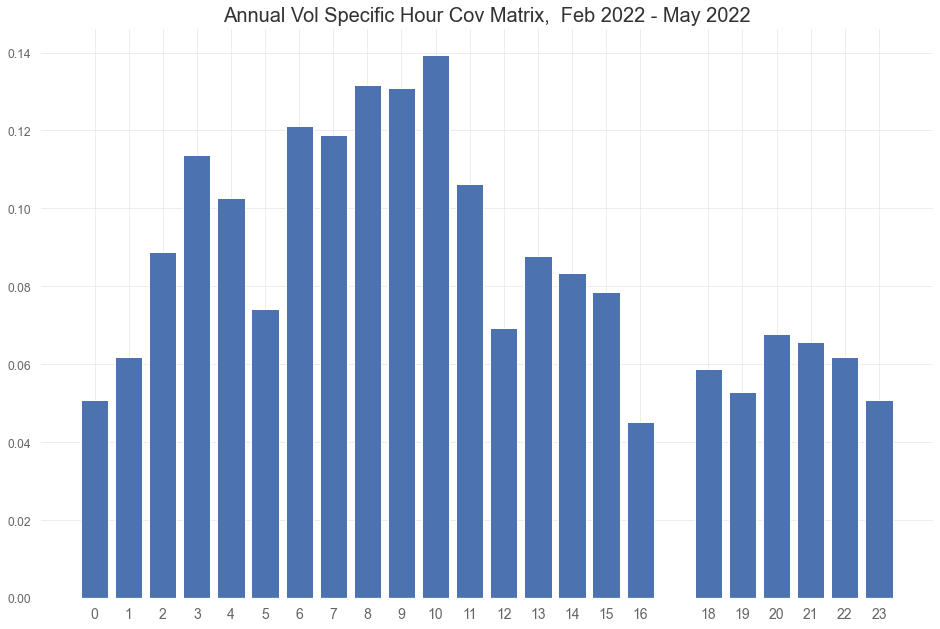

In [39]:
vol_rolling_ann= np.array(vol_rolling)*(23*252)**(1/2)
plt.bar(weight_df.index,vol_rolling_ann)
plt.title("Annual Vol Specific Hour Cov Matrix,  Feb 2022 - May 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)

### Linear Combination of All Day Covariance and by the hour covariance Static
Find winning linear combination to reduce variance

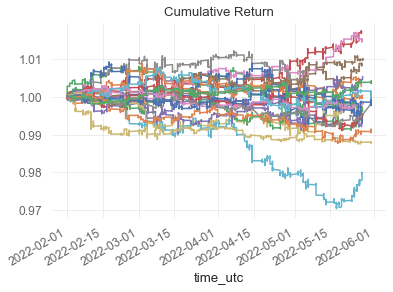

In [51]:
def cov_combo(cov_1,cov_2, delta):
    combo_cov = cov_1 * delta + (1-delta) * cov_2
    return combo_cov
s_date = '2022-1-31'
combo_static_portfolios ={}
combo_static_portfolios_vol =[]
combo_static_dict = {}
cumul_comb_returns_static_dict = {}
combo_returns_static_dict ={}
cov_daily = minute_df_usd_returns_tr[:s_date].cov()
delta = .1
for x in df_dict.keys():
    cov_hour = returns_dict[x][:s_date].cov()
    cov_ = cov_combo(cov_daily,cov_hour, delta)
    port_m = u.portfolio.markowitz_rebalance(returns_dict[x],None,len(returns_dict[x][:s_date]),static_start_date=s_date,verbose=False,returns_data=True, cov_mat=cov_)
    combo_static_portfolios[x] = port_m
    bt = u.backtest.portfolio_backtest(port_m,returns_dict[x], returns_data=True)
    cumul_comb_returns_static_dict[x]=bt[0]
    combo_static_portfolios_vol.append(bt[1])
    combo_returns_static_dict[x] =bt[2]

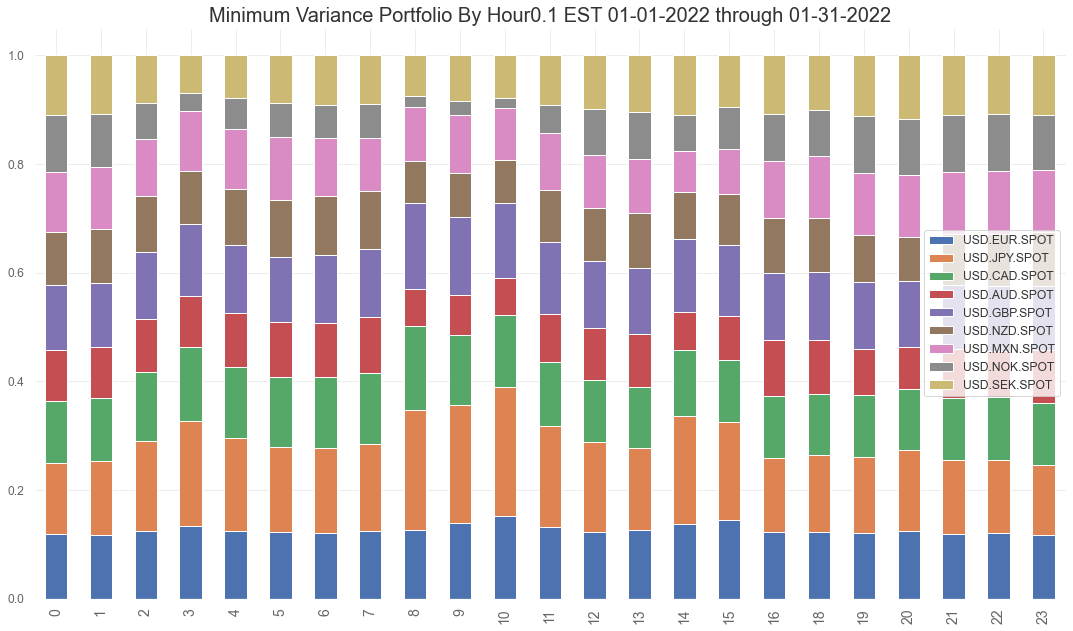

In [52]:
weight_df_c = pd.concat(combo_static_portfolios, axis=0).droplevel(axis=0,level=0)
weight_df_c.index = weight_df_c.index.hour
ax = weight_df_c.plot.bar(stacked=True)
ax.legend(loc=5)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
ax.axes.set_title("Minimum Variance Portfolio By Hour" + str(delta) + " EST 01-01-2022 through 01-31-2022", fontsize=20)
plt.xticks(fontsize=14)
plt.savefig('../plots/Min_var_port_weights_hour_delta' + str(delta) + ".png")

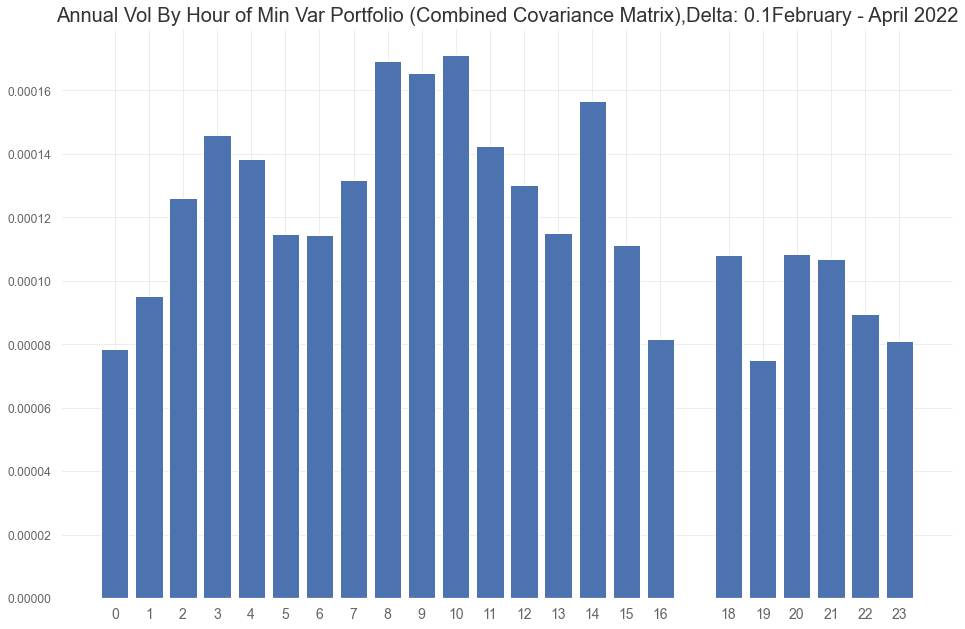

In [53]:
combo_static_portfolios_vol_ann= np.array(combo_static_portfolios_vol)*(60*23*252)**(1/2)
plt.bar(weight_df_c.index,combo_static_portfolios_vol)
plt.title("Annual Vol By Hour of Min Var Portfolio (Combined Covariance Matrix),Delta: " + str(delta) + "February - April 2022", fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=14)
plt.savefig('../plots/Min_var_annual_vol_hour_delta_' + str(delta) + ".png")

### Volatility by hour of portfolio based on only daily

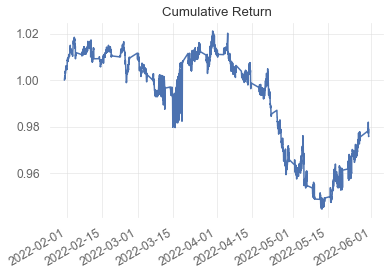

In [43]:
s_date = '2022-1-31'
port_daily = u.portfolio.markowitz_rebalance(minute_df_usd_returns_tr,60,60*10*23,static_start_date=s_date,verbose=False,returns_data=True)
bt_daily = u.backtest.portfolio_backtest(port_daily,minute_df_usd_returns_tr, returns_data=True)

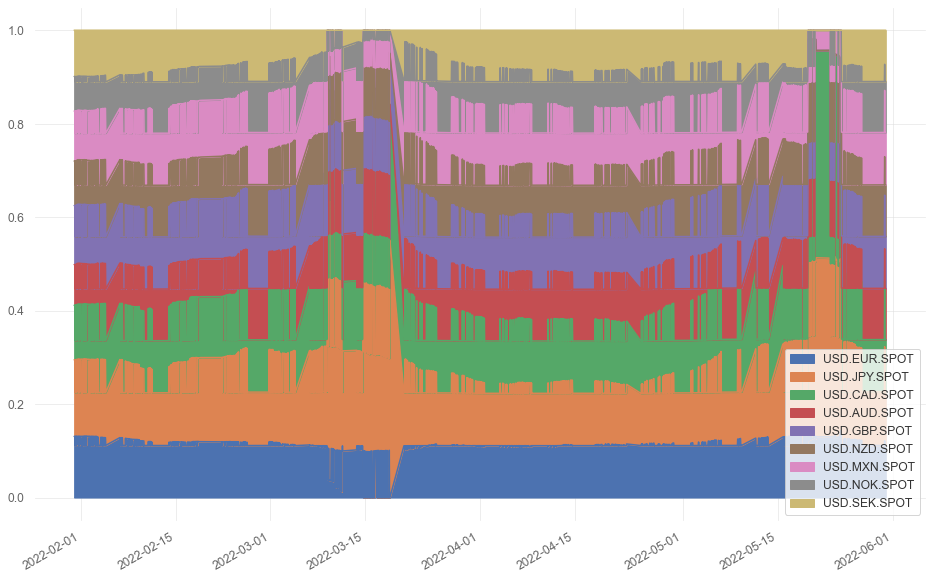

In [24]:
port_daily.plot.area()
fig = plt.gcf()
fig.set_size_inches(16, 10.5)

In [44]:
returns_daily_dict = {}
vol_daily_list = []
for p in range(0,24):
    if p!=17:
        returns_daily_dict[p] = bt_daily[2][bt_daily[2].index.hour ==p]
        vol_daily_list.append(returns_daily_dict[p].std()*(23*252)**(1/2))

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

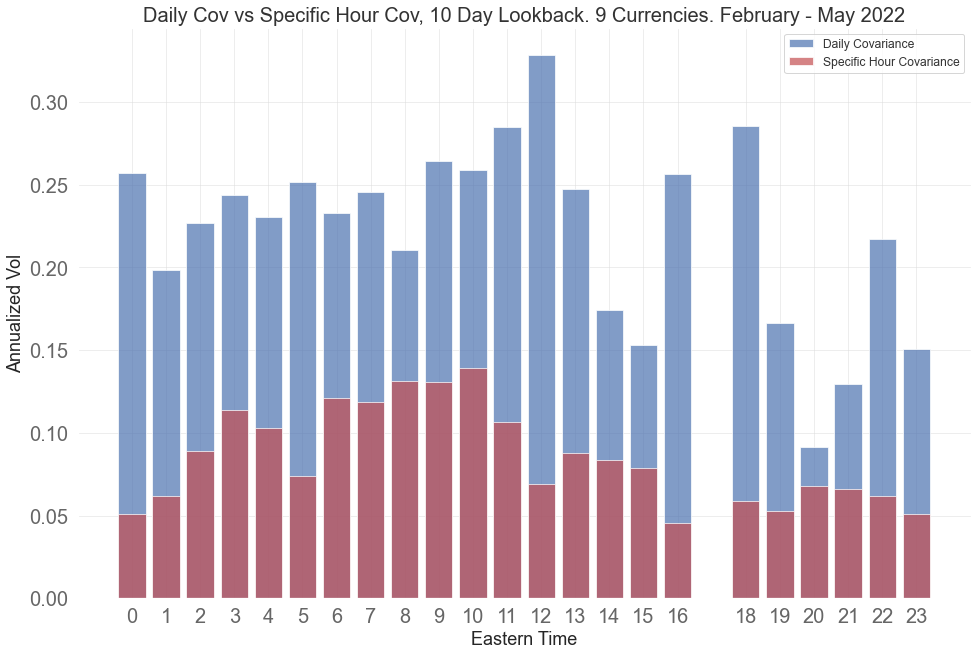

In [50]:
plt.bar(weight_df.index,vol_daily_list, alpha=.7)
plt.bar(weight_df.index,vol_rolling_ann, alpha=.7, color='r')

plt.legend([ 'Daily Covariance', 'Specific Hour Covariance',])
plt.title("Daily Cov vs Specific Hour Cov, 10 Day Lookback. 9 Currencies. February - May 2022", fontsize=20)
plt.xlabel('Eastern Time', fontsize=18)
plt.ylabel('Annualized Vol', fontsize=18)
fig = plt.gcf()
fig.set_size_inches(16, 10.5)
plt.xticks(weight_df.index,fontsize=20)
plt.yticks(fontsize = 20)

In [46]:
cov_by_hour_returns = pd.concat(returns_rolling_dict).droplevel(level=0)
cov_by_hour_returns = cov_by_hour_returns.sort_index().dropna()

(array([19024., 19038., 19052., 19066., 19083., 19097., 19113., 19127.,
        19144.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

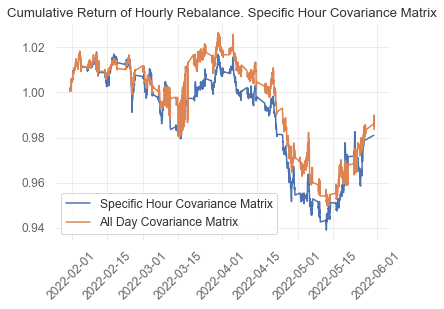

In [47]:
plt.plot(1+cov_by_hour_returns.cumsum())
plt.plot(1+bt_daily[2].cumsum())
plt.legend(['Specific Hour Covariance Matrix', 'All Day Covariance Matrix'])
plt.plot()
plt.title('Cumulative Return of Hourly Rebalance. Specific Hour Covariance Matrix')
plt.xticks(rotation=45)

In [111]:
equal_weight = hour_df_usd_returns_tr.loc['02-01-2022':].sum(axis=1)/9

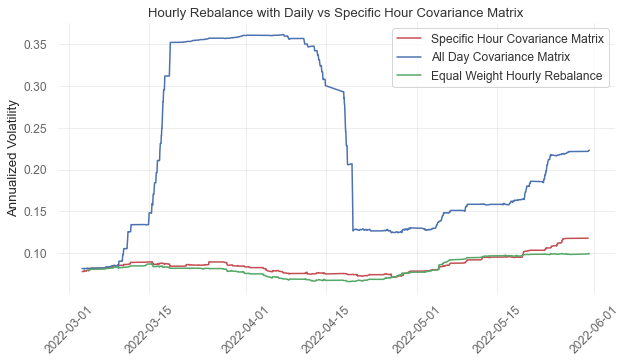

In [115]:
plt.plot(cov_by_hour_returns.rolling(23*21).std()*(23*252)**(1/2), color='r')
plt.plot(bt_daily[2].rolling(23*21).std()*(23*252)**(1/2),color='b')
plt.plot(equal_weight.rolling(21*23).std()*(23*252)**(1/2), color='g')
plt.legend(['Specific Hour Covariance Matrix', 'All Day Covariance Matrix', 'Equal Weight Hourly Rebalance'])
plt.title('Hourly Rebalance with Daily vs Specific Hour Covariance Matrix')
plt.xticks(rotation=45)
plt.ylabel('Annualized Volatility')
fig = plt.gcf()
fig.set_size_inches(10, 5)